In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score

In [2]:
import os
import sys
import re
import string
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [3]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau

/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences


In [7]:
ngram_range = 2
max_features = 20000
maxlen = 300
embedding_dims = 60

In [8]:
data = pd.read_csv('../data/train.csv')
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
comments = data['comment_text'].fillna('UNK').values
y = data[classes].values
train_comments, val_comments, y_train, y_val = train_test_split(comments, y, test_size=0.1, random_state=42)

In [9]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_comments)

In [10]:
X_train = tokenizer.texts_to_sequences(train_comments)
X_val   = tokenizer.texts_to_sequences(val_comments)

In [11]:
print(len(X_train), 'train sequences')
print(len(X_val), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, X_val)), dtype=int)))

143613 train sequences
15958 test sequences
Average train sequence length: 65
Average test sequence length: 62


In [12]:
print('Adding {}-gram features'.format(ngram_range))
# Create set of unique n-gram from the training set.
ngram_set = set()
for input_list in X_train:
    for i in range(2, ngram_range + 1):
        set_of_ngram = create_ngram_set(input_list, ngram_value=i)
        ngram_set.update(set_of_ngram)

# Dictionary mapping n-gram token to a unique integer.
# Integer values are greater than max_features in order
# to avoid collision with existing features.
start_index = max_features + 1
token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
indice_token = {token_indice[k]: k for k in token_indice}

# max_features is the highest integer that could be found in the dataset.
max_features = np.max(list(indice_token.keys())) + 1

# Augmenting x_train and x_test with n-grams features
X_train = add_ngram(X_train, token_indice, ngram_range)
X_val = add_ngram(X_val, token_indice, ngram_range)
print('Average train sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, X_val)), dtype=int)))

Adding 2-gram features
Average train sequence length: 130
Average test sequence length: 117


In [13]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = sequence.pad_sequences(X_val, maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_val.shape)

Pad sequences (samples x time)
x_train shape: (143613, 300)
x_test shape: (15958, 300)


In [42]:
print('Build model...')
model = Sequential()

model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Build model...


In [30]:
MODEL_PATH = '../models/fasttext.h5'

In [15]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_ckpt = ModelCheckpoint(filepath='../models/fasttext.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3)
history = History()
auc_monitor = RocAucEvaluation(interval=1, validation_data=(X_val, y_val))
callbacks = [model_ckpt, reduce_lr, early_stopping, history, auc_monitor]

In [20]:
model.fit(X_train, y_train, batch_size=512,  epochs=100, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 143613 samples, validate on 15958 samples
Epoch 1/100
143613/143613 [==============================] - 36s 250us/step - loss: 0.1477 - acc: 0.9634 - val_loss: 0.1348 - val_acc: 0.9641

 ROC-AUC - epoch: 1 - score: 0.830776 

Epoch 2/100
143613/143613 [==============================] - 36s 251us/step - loss: 0.1331 - acc: 0.9635 - val_loss: 0.1264 - val_acc: 0.9641

 ROC-AUC - epoch: 2 - score: 0.878487 

Epoch 3/100
143613/143613 [==============================] - 36s 250us/step - loss: 0.1245 - acc: 0.9636 - val_loss: 0.1205 - val_acc: 0.9641

 ROC-AUC - epoch: 3 - score: 0.890130 

Epoch 4/100
143613/143613 [==============================] - 36s 250us/step - loss: 0.1176 - acc: 0.9637 - val_loss: 0.1151 - val_acc: 0.9643

 ROC-AUC - epoch: 4 - score: 0.904015 

Epoch 5/100
143613/143613 [==============================] - 36s 250us/step - loss: 0.1106 - acc: 0.9640 - val_loss: 0.1092 - val_acc: 0.9646

 ROC-AUC - epoch: 5 - score: 0.915960 

Epoch 6/100
143613/143613 [=======

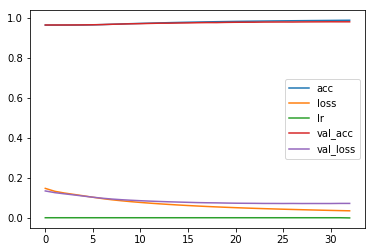

In [24]:
%matplotlib inline
pd.DataFrame(history.history).plot()

In [43]:
model.load_weights('../models/fasttext.h5')

In [30]:
y_pred_train = model.predict(X_train, verbose=1)

143613/143613 [==============================] - 4s 27us/step


In [31]:
roc_auc_score(y_train, y_pred_train)

0.9862173175088156

In [54]:
X = tokenizer.texts_to_sequences(data.comment_text.fillna('UNK').values)
X = sequence.pad_sequences(X, maxlen=maxlen)

In [56]:
features = pd.DataFrame(columns=data.columns)
features['id'] = data['id']
features.loc[:, classes] = model.predict(X)
features = features.drop('comment_text', axis=1)
features.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,0.000578447,0.000367105,0.000257865,0.000748244,0.000309909,0.00129133
1,000103f0d9cfb60f,0.00930162,0.00278877,0.00400143,0.00231657,0.00431788,0.00493252
2,000113f07ec002fd,0.0243203,0.000890426,0.00468139,0.000977447,0.00430527,0.00239343
3,0001b41b1c6bb37e,2.8504e-06,1.97048e-06,6.93202e-07,3.69452e-05,1.07812e-06,4.93221e-05
4,0001d958c54c6e35,0.165686,0.009898,0.0524718,0.00425096,0.0491006,0.0115092


In [57]:
features.to_csv('../data/features/fasttext.csv', index=False)

In [32]:
test = pd.read_csv('../data/test.csv')
test_comments = test['comment_text'].fillna('UNK')
test_sequences = tokenizer.texts_to_sequences(test_comments)
X_test = sequence.pad_sequences(test_sequences, maxlen = maxlen)

In [33]:
y_pred = model.predict(X_test, verbose=1)

153164/153164 [==============================] - 4s 29us/step


In [34]:
sub = pd.read_csv('../data/sample_submission.csv')
sub.iloc[:, 1:] = y_pred
sub.to_csv('../submissions/fasttext.csv', index=False)